<a href="https://colab.research.google.com/github/nedalaltiti/Deploying-a-ML-Model-to-Cloud-Application-Platform-with-FastAPI/blob/master/nbs/models.lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#| default_exp models.lstm
%%capture
!pip install datasetsforecast neuralforecast

In [1]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasetsforecast.m4 import M4
# from datasetsforecast.m3 import M3
from neuralforecast.core import NeuralForecast
from utilsforecast.losses import mae
from utilsforecast.plotting import plot_series
from neuralforecast.models.lstm import LSTM

In [2]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [3]:
torch.cuda.is_available()


False

# Import M4 Dataset

In [4]:
# m4_df, _, _ = M4.load(directory='./', group='Monthly', cache=True)
# m4_df['ds'] = pd.to_datetime(m4_df['ds'])
# m4_df.to_pickle("m4_dataset.pkl")

In [5]:
m4_df = pd.read_pickle("m4_dataset.pkl")
m4_df

,unique_id,ds,y
0,M1,1970-01-01 00:00:00.000000001,8000.0
1,M1,1970-01-01 00:00:00.000000002,8350.0
2,M1,1970-01-01 00:00:00.000000003,8570.0
3,M1,1970-01-01 00:00:00.000000004,7700.0
4,M1,1970-01-01 00:00:00.000000005,7080.0
...,...,...,...
11246406,M9999,1970-01-01 00:00:00.000000083,4200.0
11246407,M9999,1970-01-01 00:00:00.000000084,4300.0
11246408,M9999,1970-01-01 00:00:00.000000085,3800.0
11246409,M9999,1970-01-01 00:00:00.000000086,4400.0


#Import M3 Dataset

In [10]:
# m3_df, _, _ = M3.load(directory='./', group='Monthly')
# m3_df['ds'] = pd.to_datetime(m3_df['ds'])
# m3_df.to_pickle("m3_dataset.pkl")

In [6]:
m3_df = pd.read_pickle("m3_dataset.pkl")
m3_df

,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0
...,...,...,...
167557,M999,1993-10-31,5225.9
167558,M999,1993-11-30,5236.3
167559,M999,1993-12-31,5186.6
167560,M999,1994-01-31,5143.4


#Conver M4 and M3 from long format to wide format

In [7]:
def convert_to_wide_format(df, unique_id_col="unique_id", date_col="ds", value_col="y"):
    """
    Converts a long-format time series dataset into a wide-format dataset.

    Parameters:
    - df (pd.DataFrame): Input dataframe with time series data in long format.
    - unique_id_col (str): Column name for unique time series identifiers.
    - date_col (str): Column name for timestamp values.
    - value_col (str): Column name for observed values.

    Returns:
    - df_wide (pd.DataFrame): Wide-format dataframe with unique_id as index and sequential columns (V1, V2, ...).
    - time_index (pd.Series): Timestamps corresponding to the sequential columns.
    """
    # Ensure 'ds' is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Sort by unique_id and timestamp to maintain order
    df = df.sort_values(by=[unique_id_col, date_col]).reset_index(drop=True)

    # Assign sequential time step numbers
    df["time_step"] = df.groupby(unique_id_col).cumcount() + 1

    # Save the timestamps separately (assuming all time series share the same `ds`)
    time_index = df[df[unique_id_col] == df[unique_id_col].iloc[0]][date_col].reset_index(drop=True)

    # Pivot to wide format
    df_wide = df.pivot(index=unique_id_col, columns="time_step", values=value_col)

    # Rename columns to V1, V2, V3, ...
    df_wide.columns = [f"V{i}" for i in range(1, len(df_wide.columns) + 1)]

    # Reset index to make unique_id a column again
    df_wide.reset_index(inplace=True)

    # Ensure sorting is maintained
    df_wide = df_wide.sort_values(by=unique_id_col).reset_index(drop=True)

    # Ensure unique_id is treated as a string
    df_wide[unique_id_col] = df_wide[unique_id_col].astype(str)

    # Sort unique_id numerically, extracting the number part for proper ordering
    df_wide = df_wide.sort_values(by=unique_id_col, key=lambda x: x.str.extract('(\d+)')[0].astype(int))

    # Reset index to maintain clean numbering
    df_wide = df_wide.reset_index(drop=True)

    return df_wide, time_index

# Example Usage
# m4_df = pd.read_pickle("m4_dataset.pkl")
m4_df, m4_time_index = convert_to_wide_format(m4_df)

# m3_df = pd.read_pickle("m3_dataset.pkl")
m3_df, m3_time_index = convert_to_wide_format(m3_df)

m4_df.shape, m3_df.shape

#Split M4 and M3 Dataset to Train and Test

In [11]:
def split_train_test(df, unique_id_col="unique_id", forecast_horizon=18):
    """
    Optimized version of train-test split for wide-format time series.

    Parameters:
    - df (pd.DataFrame): Wide-format dataframe where each row represents a time series
                         and columns (V1, V2, ...) represent time steps.
    - unique_id_col (str): Column name for unique time series identifiers.
    - forecast_horizon (int): Number of last observations to withhold for testing.

    Returns:
    - train_df (pd.DataFrame): Training dataset with last `forecast_horizon` points removed.
    - test_df (pd.DataFrame): Test dataset containing only the last `forecast_horizon` points.
    """
    df = df.set_index(unique_id_col)  # Set unique_id as index

    # Convert to NumPy for efficiency
    numeric_data = df.to_numpy(copy=True)  # Avoid modifying original data

    # Identify valid data points per row
    valid_lengths = (~np.isnan(numeric_data)).sum(axis=1)  # Count non-NaN values per row

    # Pre-allocate arrays for efficiency
    train_data = np.full_like(numeric_data, np.nan)  # Same shape, filled with NaNs
    test_data = np.full((numeric_data.shape[0], forecast_horizon), np.nan)  # Test set shape

    # Vectorized operation
    for i in range(numeric_data.shape[0]):
        valid_series = numeric_data[i, :valid_lengths[i]]  # Extract valid values
        if valid_lengths[i] > forecast_horizon:
            train_data[i, :valid_lengths[i] - forecast_horizon] = valid_series[:-forecast_horizon]
            test_data[i, :forecast_horizon] = valid_series[-forecast_horizon:]
        else:
            train_data[i, :valid_lengths[i]] = valid_series  # All in train if too short

    # Convert back to DataFrame
    train_df = pd.DataFrame(train_data, index=df.index, columns=df.columns)
    test_df = pd.DataFrame(test_data, index=df.index, columns=[f"V{i}" for i in range(1, forecast_horizon + 1)])

    # Reset index
    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)

    return train_df, test_df

# Apply function to M4 and M3 datasets
m4_train, m4_test = split_train_test(m4_df)
m3_train, m3_test = split_train_test(m3_df)

m4_train.shape, m4_test.shape, m3_train.shape, m3_test.shape

((48000, 2813), (48000, 19), (1428, 145), (1428, 19))

In [14]:
m4_train

,unique_id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V2803,V2804,V2805,V2806,V2807,V2808,V2809,V2810,V2811,V2812
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,M47996,9964.0,7212.0,7858.0,8493.0,8203.0,8362.0,7238.0,7357.0,8642.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47996,M47997,1696.6,1627.2,1465.4,1672.8,1760.1,1974.8,1733.7,1898.0,1952.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47997,M47998,5900.0,6000.0,6280.0,6100.0,5410.0,5320.0,5130.0,5330.0,5810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47998,M47999,4660.0,4980.0,5060.0,5090.0,4790.0,4840.0,4640.0,4770.0,4940.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Ensure unique_id is treated as a string
m4_df['unique_id'] = m4_df['unique_id'].astype(str)

# Sort unique_id numerically, extracting the number part for proper ordering
m4_df = m4_df.sort_values(by="unique_id", key=lambda x: x.str.extract('(\d+)')[0].astype(int))

# Reset index to maintain clean numbering
m4_df = m4_df.reset_index(drop=True)

In [29]:
m4_df

,unique_id,ds,y
0,M1,1970-01-01 00:00:00.000000001,8000.0
1,M1,1970-01-01 00:00:00.000000333,4900.0
2,M1,1970-01-01 00:00:00.000000332,5110.0
3,M1,1970-01-01 00:00:00.000000331,5160.0
4,M1,1970-01-01 00:00:00.000000330,5420.0
...,...,...,...
11246406,M48000,1970-01-01 00:00:00.000000047,3230.0
11246407,M48000,1970-01-01 00:00:00.000000048,3730.0
11246408,M48000,1970-01-01 00:00:00.000000049,4500.0
11246409,M48000,1970-01-01 00:00:00.000000043,4620.0


In [26]:
m4_df['V2812'].dtype

dtype('float64')

In [14]:
df_wide = m3_df.pivot(index="unique_id", columns="ds", values="y")
print(df_wide.shape)

(1428, 1778)


In [16]:
max_length = m3_df.groupby('unique_id').size().max()
print(f"Maximum series length: {max_length}")

Maximum series length: 144


In [19]:
m3_df['ds'] = pd.to_datetime(m3_df['ds'])

In [25]:
df_check = m3_df.query("unique_id == 'M100'")
df_check_wide = df_check.pivot(index="unique_id", columns="ds", values="y")
print(df_check_wide)

ds         1990-01-31  1990-02-28  1990-03-31  1990-04-30  1990-05-31  \
unique_id                                                               
M100          11700.0      8020.0      8450.0      7740.0      7920.0   

ds         1990-06-30  1990-07-31  1990-08-31  1990-09-30  1990-10-31  ...  \
unique_id                                                              ...   
M100           7850.0      7990.0      7840.0      7230.0      7670.0  ...   

ds         1994-12-31  1995-01-31  1995-02-28  1995-03-31  1995-04-30  \
unique_id                                                               
M100           6180.0      6620.0      5510.0      5410.0      4810.0   

ds         1995-05-31  1995-06-30  1995-07-31  1995-08-31  1995-09-30  
unique_id                                                              
M100           4840.0      5960.0      4860.0      5050.0      4360.0  

[1 rows x 69 columns]


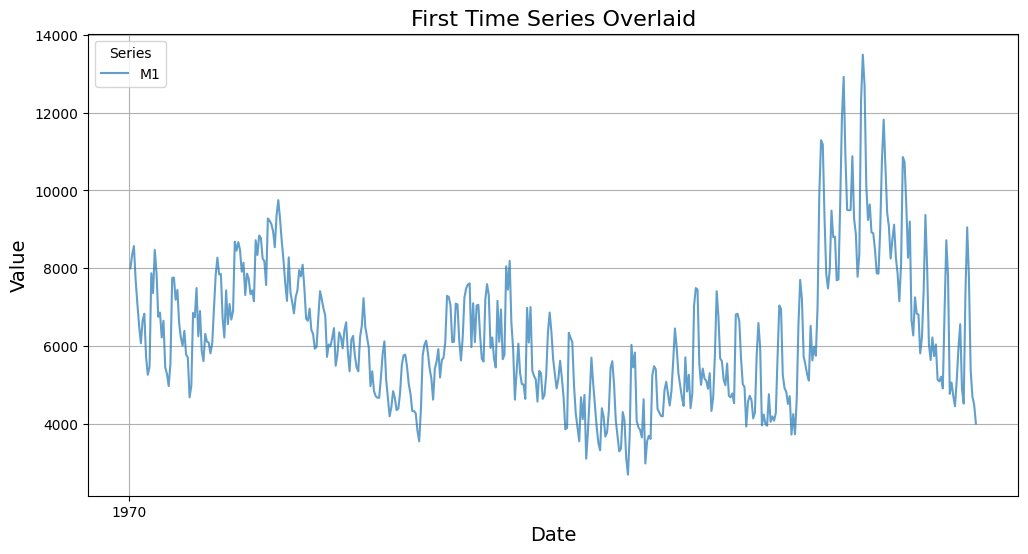

In [42]:
selected_series = df_wide.iloc[:, :1]

# Plot the first 5 time series
plt.figure(figsize=(12, 6))
for column in selected_series:
    plt.plot(selected_series.index, selected_series[column], label=column, alpha=0.7)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("First Time Series Overlaid", fontsize=16)
plt.legend(title="Series", loc="upper left")
plt.grid(True)
plt.show()

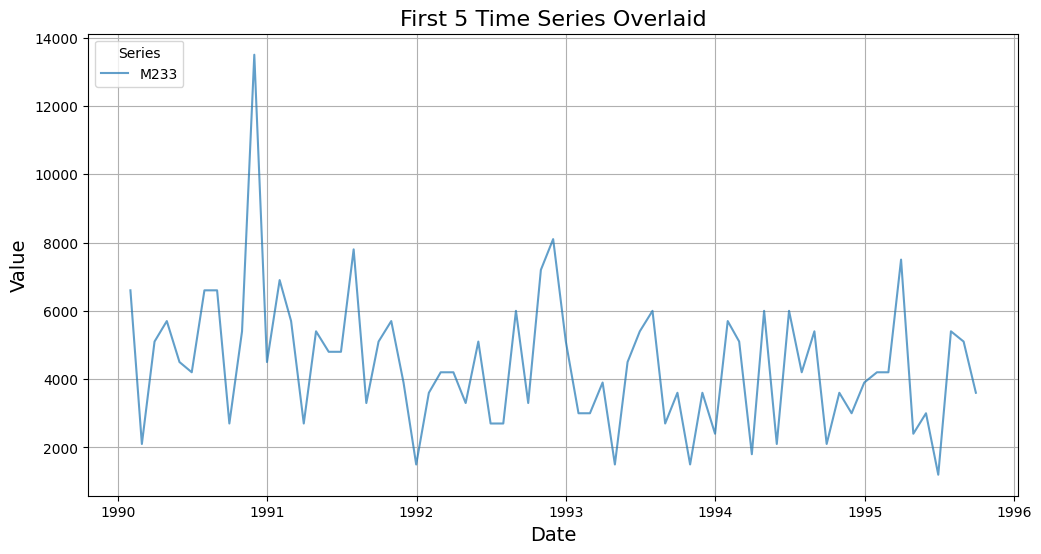

In [44]:
# Pivot data to wide format for plotting
df_wide = m3_df.pivot(index="ds", columns="unique_id", values="y")

selected_series = df_wide.iloc[:, 578:579]

# Plot the first 5 time series
plt.figure(figsize=(12, 6))
for column in selected_series:
    plt.plot(selected_series.index, selected_series[column], label=column, alpha=0.7)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("First 5 Time Series Overlaid", fontsize=16)
plt.legend(title="Series", loc="upper left")
plt.grid(True)
plt.show()

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# LSTM

The Long Short-Term Memory Recurrent Neural Network (`LSTM`), uses a multilayer `LSTM` encoder and an `MLP` decoder. It builds upon the LSTM-cell that improves the exploding and vanishing gradients of classic `RNN`'s. This network has been extensively used in sequential prediction tasks like language modeling, phonetic labeling, and forecasting. The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{LSTM}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>-[Jeffrey L. Elman (1990). "Finding Structure in Time".](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1)<br>-[Haşim Sak, Andrew Senior, Françoise Beaufays (2014). "Long Short-Term Memory Based Recurrent Neural Network Architectures for Large Vocabulary Speech Recognition."](https://arxiv.org/abs/1402.1128)<br>

![Figure 1. Long Short-Term Memory Cell.](https://github.com/Nixtla/neuralforecast/blob/feat%2Fhuberized_qloss/nbs/imgs_models/lstm.png?raw=1)

In [ ]:
#| hide
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP

In [ ]:
#| export
class LSTM(BaseRecurrent):
    """ LSTM

    LSTM encoder, with MLP decoder.
    The network has `tanh` or `relu` non-linearities, it is trained using
    ADAM stochastic gradient descent. The network accepts static, historic
    and future exogenous data.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `inference_input_size`: int, maximum sequence length for truncated inference. Default -1 uses all history.<br>
    `encoder_n_layers`: int=2, number of layers for the LSTM.<br>
    `encoder_hidden_size`: int=200, units for the LSTM's hidden state size.<br>
    `encoder_activation`: str=`tanh`, type of LSTM activation from `tanh` or `relu`.<br>
    `encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within LSTM units.<br>
    `encoder_dropout`: float=0., dropout regularization applied to LSTM outputs.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
    """
    # Class attributes
    SAMPLING_TYPE = 'recurrent'

    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 inference_input_size: int = -1,
                 encoder_n_layers: int = 2,
                 encoder_hidden_size: int = 200,
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size = 32,
                 valid_batch_size: Optional[int] = None,
                 scaler_type: str = 'robust',
                 random_seed = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 **trainer_kwargs):
        super(LSTM, self).__init__(
            h=h,
            input_size=input_size,
            inference_input_size=inference_input_size,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            scaler_type=scaler_type,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )

        # LSTM
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_bias = encoder_bias
        self.encoder_dropout = encoder_dropout

        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)

        # LSTM input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size

        # Instantiate model
        self.hist_encoder = nn.LSTM(input_size=input_encoder,
                                    hidden_size=self.encoder_hidden_size,
                                    num_layers=self.encoder_n_layers,
                                    bias=self.encoder_bias,
                                    dropout=self.encoder_dropout,
                                    batch_first=True)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):

        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1) # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # RNN forward
        hidden_state, _ = self.hist_encoder(encoder_input) # [B, seq_len, rnn_hidden_state]

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            hidden_state = torch.cat(( hidden_state, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(hidden_state)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        output = self.mlp_decoder(context)
        output = self.loss.domain_map(output)

        return output

In [ ]:
show_doc(LSTM)

In [ ]:
show_doc(LSTM.fit, name='LSTM.fit')

In [ ]:
show_doc(LSTM.predict, name='LSTM.predict')

## Usage Example

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[LSTM(h=12, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=200,
                 futr_exog_list=['y_[lag12]'],
                 #hist_exog_list=['y_[lag12]'],
                 stat_exog_list=['airline1'],
                 )
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic)
Y_hat_df = nf.predict(futr_df=Y_test_df)

Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['LSTM'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['LSTM-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['LSTM-lo-90'][-12:].values,
                 y2=plot_df['LSTM-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()